In [1]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
import h5py
#do not rerun
h.load_file('stdrun.hoc')
h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","x86_64",".libs","libnrnmech.so"))
fileList = ['class_pyramidalcell.hoc','class_axoaxoniccell.hoc', 'class_pvbasketcell.hoc', 'class_olmcell.hoc']
for item in fileList:
    h.load_file(os.path.join("biophys_components","templates",item))
callNames = ["h." + fileList[i].split('_')[1].split('.')[0] + "()" for i in range(len(fileList))]
callNames.sort()

In [ ]:
def getSynName(paramsDict):# so you don't have to track it down in the synapses.py file
    '''
    assumes file w/ synapses is called 'synapses.py' and is in the root directory
    assumes paramsDict has filename of the .json
    assumes the synapse is initialized as the variable 'lsyn' for example:
    lsyn = h.pyr2int(blablablah) 
    
    '''
    if type(paramsDict) == dict:
        fileName = paramsDict['filename']
    else:
        fileName = paramsDict
        
    fp = open(os.path.join("biophys_components","synaptic_models",fileName))
    data =json.load(fp)
    
    with open('synapses.py') as f:
        for i,item in enumerate(f):
            if ('add_synapse_model' in item) & (data['level_of_detail'] in item):
                funcName = item.split('add_synapse_model')[1].split('(')[1].split(',')[0]#very specific to how synapses.py is organized. not recommended)

    with open('synapses.py') as f:
        found = 0
        decLine = ''
        for i, item in enumerate(f):
            if 'def '+funcName in item:
                found = 1
                
            if (found == 1) & ('lsyn' in item):
                decLine = item
                found = 0 #only want the one
        synName = decLine.split('h.')[1].split('(')[0]
    return synName

In [ ]:
def getSyn_vars(fileName,sectionName,key_str):
    '''
    takes json name, the mod file section heading name, and the string you want to search in it.
    i.e., to get all the synaptic conductances' variable names:
    getSyn_vars('PN2CHN.json','RANGE','gbar')
    returns
    ['gbar_nmda', 'gbar_ampa']
    for a mod file with nmda and ampa, for example an E->I synapse
    
    or to get all the synaptic current variable names:
    getSyn_vars('PN2CHN.json','NONSPECIFIC_CURRENT','i')
    
    '''
    
    modFile = getSynName(fileName)+'.mod'
    with open(os.path.join('biophys_components','mechanisms','modfiles',modFile)) as f:
        modDat = f.read()

    test_str = modDat
    test_sub = sectionName

    res = [i for i in range(len(test_str)) if test_str.startswith(test_sub, i)]

    varList = []
    for i in range(len(res)):
        substring = modDat[res[i]:]
        substring = substring[:substring.find('\n')]
        for item in substring.split(' '):
            if key_str in item:
                varList.append(item)
    #remove spaces and ',' or really just anything that is not alnum or underscore. so depends on user convention
    for i in range(len(varList)):
        string = varList[i]
        newStr = []
        for char in string:
            if char.isalnum() or (char == '_'):
                newStr.append(char)
        varList[i] = "".join(newStr)
    varList

    return varList

In [ ]:
def run2cellModel(paramsDict):
    #read and close the json
    f = open(os.path.join("biophys_components","synaptic_models",paramsDict['filename']))
    data =json.load(f) 

    #make the cells, iclamp, synapse,and netcon and set their attributes
    Cell1 = eval(paramsDict['cell1'])# Pyr
    Cell2 = eval(paramsDict['cell2']) # AAC    
    
    iclamp = h.IClamp(Cell1.soma[0](0.5))
    [setattr(iclamp,key,float(paramsDict['IclampParams'][key])) for key in paramsDict['IclampParams'].keys() if hasattr(iclamp,key)]

    synParams = paramsDict['synTargetParams']
    syn = eval(f"h.{getSynName(paramsDict)}(Cell2.{synParams['secName']}[{synParams['secNo']}]({synParams['segNo']}))")
    [setattr(syn,key,float(data[key])) for key in data.keys() if hasattr(syn,key)]
    attList = list(syn.__dict__)
    gSynList = []
    for item in attList:
        if 'gbar' in item:
            gSynList.append(eval(f"syn.{item}"))

    

    #pick a param to change
    [setattr(syn,key,float(paramsDict['gSyn'][key])) for key in paramsDict['gSyn'].keys() if float(paramsDict['gSyn'][key]) != -1]
    #also make into list so it can be easily switched between sims
    #syn.gbar_nmda = paramsDict['syn.gbar_nmda']
    #syn.gbar_ampa = paramsDict['syn.gbar_ampa']

    #assumes netCon is watching the soma of cell1 to decide if there is an event
    netcon = h.NetCon(Cell1.soma[0](0.5)._ref_v, syn,-10, 0, 1,sec=Cell1.soma[0])
 
    recVars = [h.Vector().record(Cell1.soma[0](0.5)._ref_v),h.Vector().record(Cell2.soma[0](0.5)._ref_v)]# somas
    synCurrentList = getSyn_vars(paramsDict['filename'],'NONSPECIFIC_CURRENT','i')
    for current in synCurrentList:
        recVars.append(h.Vector().record(eval(f"syn._ref_{current}")))
        
    tstop = paramsDict['simParams']['tstop']
    h.dt=paramsDict['simParams']['h.dt']
    h.L = paramsDict['simParams']['h.L']
    h.finitialize(paramsDict['simParams']['vinit'])
    h.continuerun(tstop)

    recVars = [np.array(recVar) for recVar in recVars]
    time = np.linspace(0,tstop,int(tstop/h.dt )+1)#+1 for some reason
    ICLAMP = np.zeros(len(time))
    ICLAMP[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt+iclamp.dur)] = iclamp.amp
    recVars.append(ICLAMP)
    recVars.append(paramsDict['gSyn'])
    #recVars.append(retList)
    return time,recVars


In [ ]:
paramsDict = {'filename'        : 'CHN2PN.json',
              'cell1'           : 'h.pyramidalcell()',#cell that is stimulated w/ iclamp
              'cell2'           : 'h.axoaxoniccell()',
              
              'simParams'       : {'tstop': 300,
                                   'h.dt' : 0.1,
                                   'h.L'  : 20,
                                   'vinit': -63,
                                  },
              
              'IclampParams'    : {'delay' : 100,
                                   'dur'   : 8,
                                   'amp'   : 0.6,
                                  },
              
              'gSyn'            : {'gbar_gaba': 0.008,                                   
                                  },

              
              'synTargetParams' :{'secName' : 'dend',
                                  'secNo'   : '6',
                                  'segNo'   : '0.5'
              
             }
             }

In [ ]:
callNames

In [ ]:
getSyn_vars('CHN2PN.json','RANGE','gbar')

In [ ]:
getSynName('CHN2PN.json')

In [ ]:
# conn1 = setEdges(net,'AAC','Pyr',[ 0.072,     400],'CHN2PN.json', [1,            1.1 ],'axon', 6, 0.5)
# conn2 = setEdges(net,'Pyr','AAC',[ 0.009635,  400],'PN2CHN.json', [0.0,        400.0],'apical', 6, 0.5)
# conn3 = setEdges(net,'PV','Pyr', [ 0.05366,   400],'PV2PN.json',  [0.0,        400.0],'somatic',0, 0.5)
# conn4 = setEdges(net,'Pyr','PV', [ 0.0238,    400],'PN2PV.json',  [0.0,        400.0],'apical', 6, 0.5)
# conn5 = setEdges(net,'PV','AAC', [ 0.135,     400],'PV2CHN.json', [0.0,        400.0],'somatic',0, 0.5)
# conn6 = setEdges(net,'PV','PV',  [ 0.135,     400],'PV2PV.json',  [0.0,        400.0],'somatic',0, 0.5)
# conn7 = setEdges(net,'OLM','Pyr',[ 0.08300,   400],'OLM2PN.json', [0.0,        400.0],'apical', 4, 0.5)
# conn8 = setEdges(net,'OLM','AAC',[ 0.0800,    400],'OLM2CHN.json',[0.0,        400.0],'apical', 4, 0.5)
# conn9 = setEdges(net,'OLM','PV', [ 0.0800,    400],'OLM2PV.json', [0.0,        400.0],'apical', 4, 0.5)
# conn10 = setEdges(net,'OLM','OLM',[ 0.0800,    400],'OLM2OLM.json',[0.0,        400.0],'basal',  0, 0.9)
# conn11 = setEdges(net,'Pyr','OLM',[  0.1320,   400],'PN2OLM.json',[0.0,        400.0],'basal',  2, 0.5)

In [ ]:
keyName = 'CHN2PN_mp'
callNamesmapped = ['CHN', 'OLM','PV','PN']
Combos = {keyName: {'filename'        : f"{keyName.split('_')[0]}.json",
              'cell1'           : callNames[callNamesmapped.index(keyName.split('2')[0].split('_')[0])],#cell that is stimulated w/ iclamp
              'cell2'           : callNames[callNamesmapped.index(keyName.split('2')[1].split('_')[0])],
              
              'simParams'       : {'tstop': 300,
                                   'h.dt' : 0.1,
                                   'h.L'  : 20,
                                   'vinit': -63,
                                  },
              
              'IclampParams'    : {'delay' : 100,
                                   'dur'   : 8,
                                   'amp'   : 0.7,
                                  },
              
              'gSyn'            : {'gbar_gaba': 2,
                                  },

              
              'synTargetParams' :{'secName' : 'axon',
                                  'secNo'   : '6',
                                  'segNo'   : '0.5'
                                 }
             }
         }

In [ ]:
time,recVars = run2cellModel(Combos[keyName])
cell1str = Combos[keyName]['cell1'].split('h.')[1].split('cell')[0]
cell2str = Combos[keyName]['cell2'].split('h.')[1].split('cell')[0]
plt.plot(time,recVars[0],label = cell1str)
plt.plot(time,recVars[1],label = cell2str)
plt.xlabel(f"gSyn = {recVars[-1]}")
plt.title(f"{cell1str}->{cell2str}")
plt.legend()
plt.show()

In [ ]:
res = 0

time,recVars = run2cellModel(Combos[keyName])
peaks, _ = find_peaks(recVars[1],height=-40)#postsynaptic cell
while(len(peaks)<1):
    time,recVars = run2cellModel(Combos[keyName])
    for key in Combos[keyName]['gSyn']:
        Combos[keyName]['gSyn'][key]+=0.1
        res = Combos[keyName]['gSyn'][key]
        print(res)
    peaks, _ = find_peaks(recVars[1],height=-40)#postsynaptic cell
    


In [ ]:

peaks1, _ = find_peaks(recVars[0],height=-40)
peaks2, _ = find_peaks(recVars[1],height=-40)
(peaks2 - peaks1)[0] * Combos[keyName]['simParams']['h.dt']

In [ ]:
peaks1

In [ ]:
recVars

In [ ]:
with open(os.path.join('twocellmodelParams',f"{keyName}.json"), 'w') as outfile:
    json.dump(Combos[keyName], outfile)

# Basic

In [2]:
iclamp_amp = 0.6

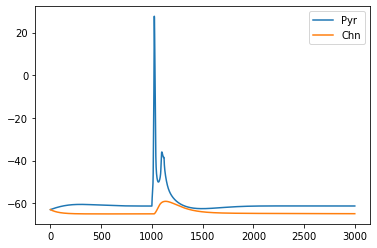

In [3]:
Cell1 = h.pyramidalcell()
Cell2 = h.axoaxoniccell()

#Pyr.soma[0].gmax_ch_HCNp = 0

iclamp = h.IClamp(Cell1.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 12
iclamp.amp =iclamp_amp


vCell1 = h.Vector().record(Cell1.soma[0](0.5)._ref_v)
vCell2 = h.Vector().record(Cell2.soma[0](0.5)._ref_v)



syn = h.oldpyr2int(Cell2.soma[0](0.5))

# AlphaTmax_gaba=1.52
# Beta_gaba=0.14
# Cdur_gaba=0.7254
# gbar_gaba=0.006
# Erev_gaba=-80
# initW=1
# Wmax=25
# Wmin=0.25
# lambda1=1
# lambda2=0.01
# threshold1=0.5
# threshold2=0.6
# tauD1=40
# d1=0.95
# tauD2=70
# d2=0.9
# tauF=20
# f=0
AlphaTmax_ampa = 10.1571
Beta_ampa=0.4167
Cdur_ampa=0.713
gbar_ampa=0.001
Erev_ampa=0
AlphaTmax_nmda=0.2659
Beta_nmda=0.008
Cdur_nmda=16.7650
gbar_nmda=0.0005
Erev_nmda=0
initW=1
lambda1=8
lambda2=0.01
threshold1=0.35
threshold2=0.4
tauD1=40
d1=0.95
tauD2=70
d2=0.9
tauF=45
f:1
bACH=0
aDA1=1
bDA=0
wACH=0
ratio=0.05
gaussa=0
isyn = h.Vector().record(syn._ref_i_nmda)


netcon = h.NetCon(Cell1.soma[0](0.5)._ref_v, syn,-10, 0, 1,sec=Cell1.soma[0])



h.dt=0.1
h.L = 20
h.finitialize(-63)
h.continuerun(300)

vCell1 = np.array(vCell1)
vCell2 = np.array(vCell2)
plt.plot(vCell1,label='Pyr')
plt.plot(vCell2 ,label='Chn')
plt.legend()
#plt.plot(iGABA)
vCell1_1 = vCell2
isyn_1 = isyn

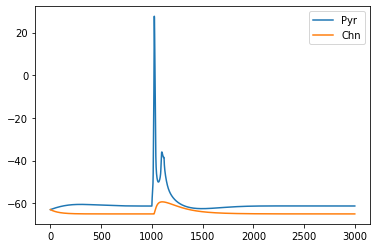

In [6]:
Cell1 = h.pyramidalcell()
Cell2 = h.axoaxoniccell()

#Pyr.soma[0].gmax_ch_HCNp = 0

iclamp = h.IClamp(Cell1.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 12
iclamp.amp =iclamp_amp


vCell1 = h.Vector().record(Cell1.soma[0](0.5)._ref_v)
vCell2 = h.Vector().record(Cell2.soma[0](0.5)._ref_v)

syn = h.AMPA_NMDA(Cell2.soma[0](0.5))


syn.initW = 1.0    
syn.tau_r_AMPA = 1.5   
syn.tau_d_AMPA = 1.7  
syn.tau_r_NMDA = 1  
syn.tau_d_NMDA = 20
syn.gmax = .045 






isyn = h.Vector().record(syn._ref_i_NMDA)


netcon = h.NetCon(Cell1.soma[0](0.5)._ref_v, syn,-10, 0, 1,sec=Cell1.soma[0])



h.dt=0.1
h.L = 20
h.finitialize(-63)
h.continuerun(300)

vCell1 = np.array(vCell1)
vCell2 = np.array(vCell2)
plt.plot(vCell1,label='Pyr')
plt.plot(vCell2 ,label='Chn')
plt.legend()
#plt.plot(iGABA)
vCell1_2 = vCell2
isyn_2 = isyn

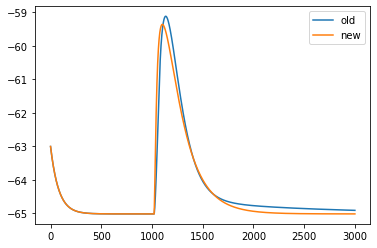

In [7]:
plt.plot(vCell1_1,label = 'old')
plt.plot(vCell1_2, label = 'new')
plt.legend()

In [7]:
np.corrcoef(vPyr1,vPyr2)

array([[1.        , 0.99993108],
       [0.99993108, 1.        ]])

In [ ]:
plt.plot(iGABA1,label = 'old')
plt.plot(iGABA2,label ='new')
plt.legend()

# automated

In [ ]:
#look at amps of all cells, and 'rheoweight'

In [ ]:
fileNames = os.listdir("twocellmodelParams")
fileNames = [fileName for fileName in fileNames if fileName.find('json') != -1]
resDict = {}
for fileName in fileNames:
    fp = open(os.path.join("twocellmodelParams",fileName))
    dictionary =json.load(fp)
    time,recVars = run2cellModel(dictionary)
    keyName = fileName.split('_')[0]
    resDict.update({keyName: recVars})
    

In [ ]:

r,c = 3,4
fig, axs = plt.subplots(r,c,figsize=(10,8))
keyCounter = 0
for i in range(r):
    for j in range(c):
        if (keyCounter) >= len(fileNames):
            break
        keyName = list(resDict.keys())[keyCounter]
        cell1str = keyName.split('2')[0]
        cell2str = keyName.split('2')[1]
        axs[i][j].plot(time,resDict[keyName][0],label = cell1str)
        axs[i][j].plot(time,resDict[keyName][1],label = cell2str)
        axs[i][j].set_title(f"{cell1str}->{cell2str}")
        #axs[i][j].set_xlim([50,200])
        #axs[i][j].set_ylim([-70,-50])
        #axs[i][j].set_xlabel(f"gSyn = {resDict[keyName][-1]}")
        axs[i][j].legend(prop = {'size':8})
        axs[i][j].set_facecolor("white")
        keyCounter+=1
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.savefig('twoCellModel',dpi=300)
plt.show()


In [ ]:
squareDim = int(len(fileNames)**.5)
r,c = 3,4
fig, axs = plt.subplots(r,c,figsize=(10,8))
keyCounter = 0
for i in range(r):
    for j in range(c):
        if (keyCounter) >= len(fileNames):
            break
        keyName = list(resDict.keys())[keyCounter]
        currentNames = getSyn_vars(f"{keyName}.json",'NONSPECIFIC_CURRENT','i')
        curr1str = currentNames[0]
        axs[i][j].plot(time,resDict[keyName][2],label = curr1str)
        gSyns = getSyn_vars(f"{keyName}.json",'RANGE','gbar')
        #print(resDict[keyName][-1])
        #xlabel = f"{gSyns[0]} = {resDict[keyName][-1][0]}"
        if len(currentNames) == 2:#only ever 1 or 2 so not generic here
            curr2str = currentNames[1]
            axs[i][j].plot(time,resDict[keyName][3],label = curr2str)
            #xlabel = f"{gSyns[0]} = {resDict[keyName][-1][0]}\n"+f"{gSyns[1]} = {resDict[keyName][-1][1]}"
        
        cell1str = keyName.split('2')[0]
        cell2str = keyName.split('2')[1]
        axs[i][j].set_title(f"{cell1str}->{cell2str}")
        
        #axs[i][j].set_xlim([50,200])
        axs[i][j].set_ylim([-0.08,0.15])
        #axs[i][j].set_xlabel(xlabel)
        axs[i][j].legend(prop = {'size':8})
        
        keyCounter+=1
plt.subplots_adjust(wspace=0.4,hspace=0.8)
plt.savefig('twoCellModel_currents',dpi=300)
plt.show()
    

In [ ]:
#print gSyn on each xaxis

# 'rheoweight'

In [ ]:
from scipy.signal import find_peaks

In [ ]:
fileNames = os.listdir("twocellmodelParams")
fileNames = [fileName for fileName in fileNames if fileName.find('json') != -1]
#fileNames = [fileName for fileName in fileNames if fileName.split('2')[0] == 'PN' or 'CHN']
fileNames = [fileName for fileName in fileNames if fileName.split('2')[0] == 'PN' or  fileName.split('_')[0] =='CHN2PN']
resDict = {}
for fileName in fileNames:
    
    fp = open(os.path.join("twocellmodelParams",fileName))
    dictionary =json.load(fp)
    time,recVars = run2cellModel(dictionary)
    _, peaks = find_peaks(recVars[1])
    for KEY in dictionary['gSyn']:
        
        dictionary['gSyn'][KEY] = 0.0005
    
    while(len(peaks)<1):
        time,recVars = run2cellModel(dictionary)
        for key in dictionary['gSyn']:
            dictionary['gSyn'][key]+=0.0005

        peaks, _ = find_peaks(recVars[1],height=-40)#postsynaptic cell

            
    keyName = fileName.split('_')[0]
    myDict = {'recVars':recVars,
             'min2spike': dictionary['gSyn']}
    resDict.update({keyName: myDict})


In [ ]:
for key in resDict:
    for KEY in resDict[key]['min2spike']:
        resDict[key]['min2spike'][KEY] = round(resDict[key]['min2spike'][KEY],4)

In [ ]:
for key in resDict:
    print(f"{key} min gsyn to spike = {resDict[key]['min2spike']}")

In [ ]:
0.0085*0.006

In [ ]:
0.0185/0.0005

In [ ]:
0.0185/0.001

In [ ]:
355000/20000

# synaptic distribution

In [ ]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
import h5py

In [ ]:
def SaveDataToDF(f):
    myData = []
    myDataNames = []
    def saveDat(item):
        if 'Data' in str(f[item].id):
            data2use = f[item][()]
            if data2use.ndim == 2:#some groups have multiple columns and this messes up the translation to a df at the end of this function
                [a,b] = data2use.shape
                for col in np.arange(0,b):
                    myData.append(data2use[:,col])
                    dataName = (f[item].name).split('/')[-1] + str(col)
                    myDataNames.append(dataName)
            else:
                myData.append(f[item][()])
                dataName = (f[item].name).split('/')[-1]
                myDataNames.append(dataName)
        
    f.visit(saveDat)
    allData = pd.DataFrame(myData).T
    allData.columns = myDataNames
    f.close()
    return allData

In [ ]:
f = h5py.File(os.path.join('network','biophysical_biophysical_edges.h5'))
firstSynsDF = SaveDataToDF(f)
f = h5py.File(os.path.join('network','biophysical_nodes.h5'), 'r')
nodesDF = SaveDataToDF(f)
cellLocations = pd.read_csv('cell_locations.csv')
idNames = np.unique(nodesDF['node_type_id'])
cellNames = np.unique(cellLocations['Cell type'])
array = cellLocations['Cell type']
idxs = np.unique(cellLocations['Cell type'],return_index=True)[1]
cellNames = [array[index] for index in sorted(idxs)]#use the names in the order in which the id's appear
nodesDF = nodesDF.replace({'node_type_id':idNames},{'node_type_id':cellNames})

srcs = nodesDF.iloc[firstSynsDF['source_node_id']]
trgts = nodesDF.iloc[firstSynsDF['target_node_id']]

newNP = np.concatenate((np.array(srcs['node_type_id']).reshape(-1,1),np.array(trgts['node_type_id']).reshape(-1,1)),axis=1)
newNP = np.hstack((newNP,np.array(firstSynsDF['syn_weight']).reshape(-1,1)))
newDFFirst = pd.DataFrame(newNP,columns = ['source','target','weight'])

In [ ]:
f = h5py.File(os.path.join('updated_conns','biophysical_biophysical_edges.h5'))
synapsesDF = SaveDataToDF(f)
f = h5py.File(os.path.join('network','biophysical_nodes.h5'), 'r')
nodesDF = SaveDataToDF(f)
cellLocations = pd.read_csv('cell_locations.csv')
idNames = np.unique(nodesDF['node_type_id'])
cellNames = np.unique(cellLocations['Cell type'])
array = cellLocations['Cell type']
idxs = np.unique(cellLocations['Cell type'],return_index=True)[1]
cellNames = [array[index] for index in sorted(idxs)]#use the names in the order in which the id's appear
nodesDF = nodesDF.replace({'node_type_id':idNames},{'node_type_id':cellNames})

df = synapsesDF['syn_weight']
df.columns = ['syn_weight','Nans']
df = df.drop(['Nans'],axis=1)
synweightsDF = df

srcs = nodesDF.iloc[synapsesDF['source_node_id']]
trgts = nodesDF.iloc[synapsesDF['target_node_id']]

newNP = np.concatenate((np.array(srcs['node_type_id']).reshape(-1,1),np.array(trgts['node_type_id']).reshape(-1,1)),axis=1)
newNP = np.hstack((newNP,np.array(synweightsDF['syn_weight']).reshape(-1,1)))
newDF = pd.DataFrame(newNP,columns = ['source','target','weight'])

In [ ]:
KeyCombos = [('Pyr','AAC'), ('Pyr','OLM'),('Pyr','PV'),('PV','PV'),('AAC','Pyr') ,('PV','AAC'),('OLM','OLM'),('OLM','PV') ]

In [ ]:
comboDict = {}
DF = newDFFirst
#DF = newDF
for i in range(len(KeyCombos)):
    A2B = DF[DF['source'].str.contains(KeyCombos[i][0]) & DF['target'].str.contains(KeyCombos[i][1])]
    #mean,std,Range = np.mean(A2B['weight']), np.std(A2B['weight']), max(A2B['weight']) -  min(A2B['weight'])
    comboDict.update({f"{KeyCombos[i][0]}2{KeyCombos[i][1]}": A2B['weight']})
    comboDict.update({f"{KeyCombos[i][0]}2{KeyCombos[i][1]}index": A2B['weight'].index})

In [ ]:
plt.figure(figsize=(10,5))
for key in comboDict:
    if 'index' in key:
        pass
    else:
        plt.hist(comboDict[key],label=key)
plt.legend()
plt.savefig('allDistributions',dpi=300)
plt.xlabel('uS')
plt.show()

In [ ]:
Name = 'AAC2Pyr'
plt.hist(comboDict[Name])

# find the cells based on a certain weight

In [ ]:
print(len(np.where(comboDict['AAC2Pyr'] > 2)[0]))
print(len(comboDict['AAC2Pyr']))
np.where(comboDict['AAC2Pyr'] > 2)[0]

In [ ]:
index = 0
oldid = comboDict['AAC2Pyrindex'][index]
newDFFirst.iloc[oldid]
firstSynsDF.iloc[oldid]['source_node_id']

In [ ]:
firstSynsDF.iloc[oldid]

In [ ]:
2/0.006

In [ ]:
synapsesDF.iloc[19769]

In [ ]:
def lognormal(m,s):    
    synaptic_weight = float(np.random.lognormal(m, s, 1)-(0.5*np.mean(np.random.lognormal(m,s,1000))))
    if synaptic_weight >= float(m*3):
        synaptic_weight = float(m*3)
    if synaptic_weight < 0:
        synaptic_weight = 0.1*m
    return synaptic_weight

In [ ]:
np.mean([lognormal(3,0.1) for i in range(10)])

In [ ]:
test = np.array([lognormal(1,0.1) for i in range(1000)])
plt.hist(test)

In [ ]:
np.median(test)

In [ ]:
len(np.where(np.array([lognormal(2,0.15) for i in range(1000)]) > 2)[0])

In [ ]:
np.mean(np.array([lognormal(2,0.15) for i in range(1000)]))

In [ ]:
plt.hist(np.array([lognormal(6,1) for i in range(1000)]))
plt.show()

In [ ]:
plt.hist(np.array([lognormal(11,0.15) for i in range(476626)]))
plt.show()


In [ ]:
plt.hist(np.random.lognormal(11, 0.15, 1000),bins=50)
plt.show()

In [ ]:
np.median(np.random.lognormal(2, 0.1, 100000))

In [ ]:
np.log(np.mean(np.random.lognormal(2, 0.001, 1000)))

In [ ]:
r,c  = 2,3
fig,axs = plt.subplots(r,c,figsize=(10,5))
Keys = list(comboDict.keys())
keyCounter = 0
for i in range(r):
    for j in range(c):
        n = axs[i][j].hist(comboDict[Keys[keyCounter]],bins=150)
        axs[i][j].set_title(Keys[keyCounter])
        axs[i][j].set_xlabel('uS')
        cell1 = Keys[keyCounter].split('2')[0]
        cell2 = Keys[keyCounter].split('2')[1]
        if 'Pyr' in cell1:
            x = np.arange(0,len(n[0]),5)
            if 'AAC' in cell2:
                axs[i][j].vlines(resDict['PN2CHN']['min2spike'][list(resDict["PN2CHN"]['min2spike'].keys())[0]],ymin=0,ymax = max(n[0]),color='r')
            elif 'OLM' in cell2:
                axs[i][j].vlines(resDict["PN2OLM"]['min2spike'][list(resDict["PN2OLM"]['min2spike'].keys())[0]],ymin=0,ymax = max(n[0]),color='r')

            elif 'PV' in cell2:
                axs[i][j].vlines(resDict["PN2PV"]['min2spike'][list(resDict["PN2PV"]['min2spike'].keys())[0]],ymin=0,ymax = max(n[0]),color='r')
        if 'AAC' in cell1:
            axs[i][j].vlines(resDict['CHN2PN']['min2spike'][list(resDict["CHN2PN"]['min2spike'].keys())[0]],ymin=0,ymax = max(n[0]),color='r')
            
        keyCounter+=1
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.savefig('synDistributions',dpi=300)
plt.show()

# Q's

In [ ]:
#how to check/set the threshold of the netcon object used in bmtk